## Hyperparam Tuning

Now that we know which models are performing better, it's time to perform cross validation and tune hyperparameters.
- Do a google search for hyperparameter ranges for each type of model.

GridSearch/RandomSearch are a great methods for checking off both of these tasks.

There is a fairly significant issue with this approach for this particular problem (described below). But in the interest of creating a basic functional pipeline, you can just use the default Sklearn methods for now.

## Preventing Data Leakage in Tuning - STRETCH

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it, if you have time!**

BUT we have a problem - if we calculated a numerical value to encode city (such as the mean of sale prices in that city) on the training data, we can't cross validate 
- The rows in each validation fold were part of the original calculation of the mean for that city - that means we're leaking information!
- While sklearn's built in functions are extremely useful, sometimes it is necessary to do things ourselves

You need to create two functions to replicate what Gridsearch does under the hood. This is a challenging, real world data problem! To help you out, we've created some psuedocode and docstrings to get you started. 

**`custom_cross_validation()`**
- Should take the training data, and divide it into multiple train/validation splits. 
- Look into `sklearn.model_selection.KFold` to accomplish this - the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html) shows how to split a dataframe and loop through the indexes of your split data. 
- Within your function, you should compute the city means on the training folds just like you did in Notebook 1 - you may have to re-join the city column to do this - and then join these values to the validation fold

This psuedocode may help you fill in the function:

```python
kfold = KFold() # fit sklearn k folds on X_train
train_folds = []
val_folds = []
for training_index, val_index in kfold.split(X_train):
    train_fold, val_fold = #.iloc loop variables on X_train

    # recompute training city means like you did in notebook 1 
    # merge to validation fold
        
    train_folds.append(train_fold)
    val_folds.append(val_fold)

    return train_folds, val_folds
```


**`hyperparameter_search()`**
- Should take the validation and training splits from your previous function, along with your dictionary of hyperparameter values
- For each set of hyperparameter values, fit your chosen model on each set of training folds, and take the average of your chosen scoring metric. [itertools.product()](https://docs.python.org/3/library/itertools.html) will be helpful for looping through all combinations of hyperparameter values
- Your function should output the hyperparameter values corresponding the highest average score across all folds. Alternatively, it could also output a model object fit on the full training dataset with these parameters.


This psuedocode may help you fill in the function:

```python
hyperparams = # Generate hyperparam options with itertools
hyperparam-scores = []
for hyperparam-combo in hyperparams:

    scores = []

    for folds in allmyfolds:
        # score fold the fold with the model/ hyperparams
        scores.append(score-fold)
        
    score = scores.mean()
    hyperparam-scores.append(score)
# After loop, find max of hyperparam-scores. Best params are at same index in `hyperparams` loop iteratble
```

Docstrings have been provided below to get you started. Once you're done developing your functions, you should move them to `functions_variables.py` to keep your notebook clean 

Bear in mind that these instructions are just one way to tackle this problem - the inputs and output formats don't need to be exactly as specified here.

In [1]:
# develop your custom functions here
from sklearn.model_selection import KFold
def custom_cross_validation(training_data, n_splits =5):
    '''creates n_splits sets of training and validation folds

    Args:
      training_data: the dataframe of features and target to be divided into folds
      n_splits: the number of sets of folds to be created

    Returns:
      A tuple of lists, where the first index is a list of the training folds, 
      and the second the corresponding validation fold

    Example:
        >>> output = custom_cross_validation(train_df, n_splits = 10)
        >>> output[0][0] # The first training fold
        >>> output[1][0] # The first validation fold
        >>> output[0][1] # The second training fold
        >>> output[1][1] # The second validation fold... etc.
    '''
    kfold = KFold(n_splits=n_splits)
    training_folds = []
    validation_folds = []
    for train_index, val_index in kfold.split(training_data):
        train_fold, val_fold = training_data.iloc[train_index], training_data.iloc[val_index]
        training_folds.append(train_fold)
        validation_folds.append(val_fold)

    return training_folds, validation_folds

def hyperparameter_search(training_folds, validation_folds, param_grid):
    '''outputs the best combination of hyperparameter settings in the param grid, 
    given the training and validation folds

    Args:
      training_folds: the list of training fold dataframes
      validation_folds: the list of validation fold dataframes
      param_grid: the dictionary of possible hyperparameter values for the chosen model

    Returns:
      A list of the best hyperparameter settings based on the chosen metric

    Example:
        >>> param_grid = {
          'max_depth': [None, 10, 20, 30],
          'min_samples_split': [2, 5, 10],
          'min_samples_leaf': [1, 2, 4],
          'max_features': ['sqrt', 'log2']} # for random forest
        >>> hyperparameter_search(output[0], output[1], param_grid = param_grid) 
        # assuming 'ouput' is the output of custom_cross_validation()
        [20, 5, 2, 'log2'] # hyperparams in order
    '''
    

    return hyperparameters


## Hyperparam Tuning

In [36]:
# perform tuning and cross validation here 
# using GridsearchCV/ RandomsearchCV (MVP)
# or your custom functions
# import models and fit
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
# Load data
train_df = pd.read_csv('../preprocessed/train_df_kai.csv')
test_df = pd.read_csv('../preprocessed/test_df_kai.csv')

# Prepare training and test sets
x_train = train_df.drop(columns=['description.sold_price'])
y_train = train_df['description.sold_price']
x_test = test_df.drop(columns=['description.sold_price'])
y_test = test_df['description.sold_price']



In [37]:

# remove outliers
index_outliers = y_test[y_test > 2000000].index
print(len(index_outliers))
x_test = x_test.drop(index_outliers)
y_test = y_test.drop(index_outliers)



13


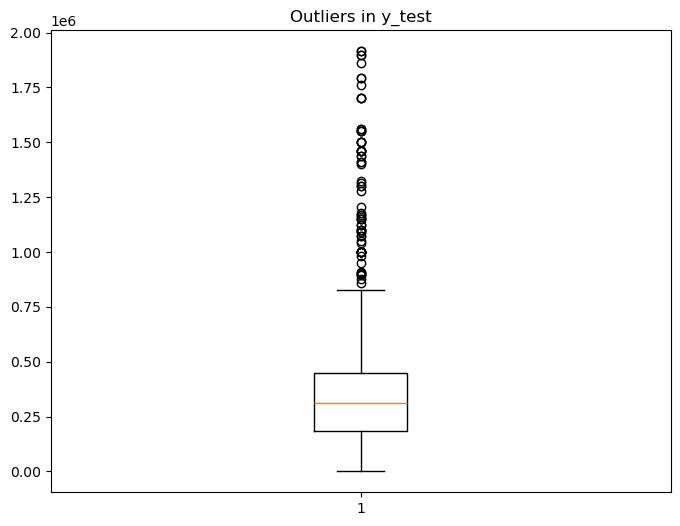

In [38]:
#outlier of y_test
plt.figure(figsize=(8, 6))
plt.boxplot(y_test)
plt.title('Outliers in y_test')
plt.show()

In [39]:
# Define feature types
numerical_features = x_train.select_dtypes(include=['float64', 'int64']).columns
categorical_features = x_train.select_dtypes(include=['object']).columns
boolean_features = x_train.select_dtypes(include=['bool']).columns

# Print to verify columns
print("Numerical features:", numerical_features)
print("Categorical features:", categorical_features)
print("Boolean features:", boolean_features)

# Define transformers
numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler()),  # Apply polynomial features to numerical data
    # ('poly', PolynomialFeatures(degree=3))
])
categorical_transformer = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
boolean_transformer = OneHotEncoder(drop='if_binary', handle_unknown='ignore')

# Create preprocessor
tree_based_preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features),
        ('bool', boolean_transformer, boolean_features)
    ])

# Create pipeline
xgb_fs = Pipeline(steps=[
    ('preprocessor', tree_based_preprocessor),
    ('model', XGBRegressor(
    ))
])

# Define a grid of parameters to search over
xgb_param_grid = {
    'model__n_estimators': [100, 200, 300, 400, 500,600,700,800,900,1000],
    'model__max_depth': [3, 5, 7,10],
    'model__learning_rate': [ 0.01, 0.02, 0.03],
    'model__reg_alpha': [0.1, 1, 10],
    'model__reg_lambda': [1,5,10],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4]
}

# Set up RandomizedSearchCV with the correct scoring parameter
grid_search = RandomizedSearchCV(xgb_fs, xgb_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)

# Fit the pipeline
grid_search.fit(x_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the model using the best model
y_pred = best_model.predict(x_test)


Numerical features: Index(['list_price', 'price_reduced_amount', 'description.year_built',
       'description.baths_3qtr', 'description.baths_full',
       'description.baths_half', 'description.lot_sqft', 'description.sqft',
       'description.baths', 'description.garage', 'description.stories',
       'description.beds', 'location.address.postal_code', 'central_air',
       'central_heat', 'community_outdoor_space',
       'community_security_features', 'dishwasher', 'fireplace',
       'hardwood_floors', 'laundry_room', 'single_story', 'garage_1_or_more',
       'garage_2_or_more', 'city_view', 'two_or_more_stories',
       'recreation_facilities', 'shopping', 'washer_dryer', 'basement', 'view',
       'forced_air', 'family_room', 'dining_room', 'city_mean_price',
       'state_mean_price'],
      dtype='object')
Categorical features: Index(['description.sub_type', 'description.type',
       'location.address.state_code'],
      dtype='object')
Boolean features: Index(['lead_attri

In [40]:
print(f'Best Parameters: {best_params}')
print(f'training score: {best_model.score(x_train, y_train)}')
print(f'test score: {best_model.score(x_test, y_test)}')
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"MAE: {mean_absolute_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")

Best Parameters: {'model__reg_lambda': 5, 'model__reg_alpha': 1, 'model__n_estimators': 1000, 'model__max_depth': 10, 'model__learning_rate': 0.03, 'model__gamma': 0.3}
training score: 0.9965957030656521
test score: 0.9904031533052057
MSE: 824864461.4420979
MAE: 3725.7607400306188
R2: 0.9904031533052057


We want to make sure that we save our models.  In the old days, one just simply pickled (serialized) the model.  Now, however, certain model types have their own save format.  If the model is from sklearn, it can be pickled, if it's xgboost, for example, the newest format to save it in is JSON, but it can also be pickled.  It's a good idea to stay with the most current methods. 
- you may want to create a new `models/` subdirectory in your repo to stay organized

In [42]:
# save your best model here
import joblib
from datetime import datetime
date_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
joblib.dump(best_model, f'../models/best_model_{date_time}.pkl')


['../models/best_model_2024-11-07_15-36-41.pkl']

In [43]:
# the description of the MAE
pd.set_option('display.float_format', '{:.2f}'.format)
print(np.abs(y_test - y_pred).describe())


count     1330.00
mean      3725.76
std      28488.48
min          0.50
25%        146.09
50%        346.73
75%        888.86
max     544763.88
Name: description.sold_price, dtype: float64


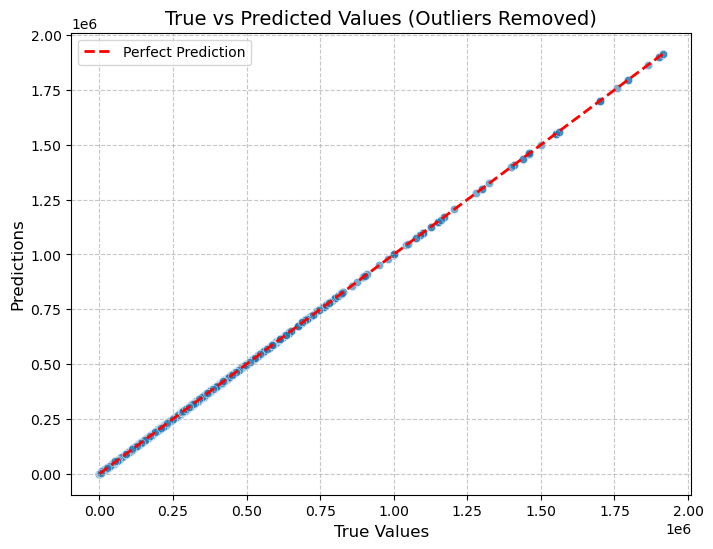

In [44]:
#viz
# Calculate residuals
residuals = y_test - y_pred

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = np.percentile(residuals, 10)
Q3 = np.percentile(residuals, 90)

# Calculate IQR
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out outliers
non_outliers = (residuals >= lower_bound) & (residuals <= upper_bound)
y_test_filtered = y_test[non_outliers]
y_pred_filtered = y_pred[non_outliers]

# Create a scatter plot without outliers
plt.figure(figsize=(8, 6))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.6, edgecolors='w', linewidth=0.5)

# Add a line for perfect predictions
max_val = max(max(y_test_filtered), max(y_pred_filtered))
min_val = min(min(y_test_filtered), min(y_pred_filtered))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

# Add labels and title
plt.xlabel('True Values', fontsize=12)
plt.ylabel('Predictions', fontsize=12)
plt.title('True vs Predicted Values (Outliers Removed)', fontsize=14)

# Add grid and legend
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.savefig('../images/scatter_plot_true_vs_predicted_values.png', dpi=300, bbox_inches='tight')
# Show plot
plt.show()

## Building a Pipeline (Stretch)

> **This step doesn't need to be part of your Minimum Viable Product (MVP), but its highly recommended you complete it if you have time!**

Once you've identified which model works the best, implement a prediction pipeline to make sure that you haven't leaked any data, and that the model could be easily deployed if desired.
- Your pipeline should load the data, process it, load your saved tuned model, and output a set of predictions
- Assume that the new data is in the same JSON format as your original data - you can use your original data to check that the pipeline works correctly
- Beware that a pipeline can only handle functions with fit and transform methods.
- Classes can be used to get around this, but now sklearn has a wrapper for user defined functions.
- You can develop your functions or classes in the notebook here, but once they are working, you should import them from `functions_variables.py` 

In [7]:
# Build pipeline here

Pipelines come from sklearn.  When a pipeline is pickled, all of the information in the pipeline is stored with it.  For example, if we were deploying a model, and we had fit a scaler on the training data, we would want the same, already fitted scaling object to transform the new data with.  This is all stored when the pipeline is pickled.
- save your final pipeline in your `models/` folder

In [8]:
# save your pipeline here